# Renekton Croc plush detector 🐊
> Along with my hand drawn arts.

## LET'S BUILD A CROCODILE, PLUSH, RENEKTON DETECTOR


In [1]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [2]:
#hide
import os
key = os.environ.get('AZURE_SEARCH_KEY', '1a25802a09ab45e4a082267f88ee5bd1')

In [11]:
reptile_types = 'crocodile','alligator plush', 'renekton'
path = Path('reptiles')

In [12]:
if not path.exists():
    path.mkdir()
    for o in reptile_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        download_images(dest, urls=results.attrgot('content_url'))

In [29]:
fns = get_image_files(path)
fns

(#416) [Path('reptiles/alligator plush/00000000.jpg'),Path('reptiles/alligator plush/00000001.jpg'),Path('reptiles/alligator plush/00000002.jpg'),Path('reptiles/alligator plush/00000003.jpg'),Path('reptiles/alligator plush/00000004.jpeg'),Path('reptiles/alligator plush/00000005.jpg'),Path('reptiles/alligator plush/00000006.jpg'),Path('reptiles/alligator plush/00000007.jpg'),Path('reptiles/alligator plush/00000008.jpg'),Path('reptiles/alligator plush/00000009.jpg')...]

In [31]:
failed = verify_images(fns)
failed.map(Path.unlink)

(#0) []

In [32]:
class DataLoaders(GetAttr):
    num_workers=0
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i, self: self[i])
        

In [33]:
reptiles = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

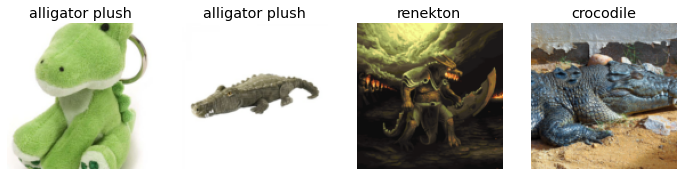

In [34]:
dls = reptiles.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [35]:
reptiles = reptiles.new(item_tfms=RandomResizedCrop(224, min_scale=0.5),
                        batch_tfms=aug_transforms())
dls = reptiles.dataloaders(path, num_workers=0) # <- num_workers=0 to prevent window error

In [36]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

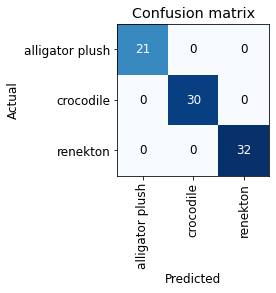

In [37]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

Result is very good

In [43]:
# cleaner = ImageClassifierCleaner(learn)
# cleaner
# for idx in cleaner.delete(): cleaner.fns[idx].unlink() # delete 

## Let's test

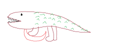

In [73]:
my_renek = PILImage.create("renek_plush.png")
display(my_renek.to_thumb(256,256))

In [75]:
pred, pred_idx, probs =learn.predict(my_renek)
f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

'Prediction: alligator plush; Probability: 0.9391'

Very good. It is very accurate since my drawing of a plush is very realistic.

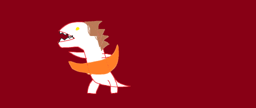

'Prediction: renekton; Probability: 0.9834'

In [77]:
renek = PILImage.create("renek_test.png")
display(renek.to_thumb(256,256))
pred, pred_idx, probs =learn.predict(renek)
f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

Easily recognizes my drawing of Renekton as well. I guess I'm an artist

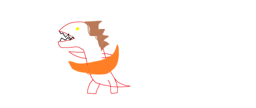

'Prediction: renekton; Probability: 0.9674'

In [78]:
renek_withoutbg = PILImage.create("renek_test1.png")
display(renek_withoutbg.to_thumb(256,256))
pred, pred_idx, probs =learn.predict(renek_withoutbg)
f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

Expected the model to predict plush becasue I removed the background but it's too smart. (In dataset a lot of plush had empty white background contrast to lots of Renekton images having dark backgrounds)

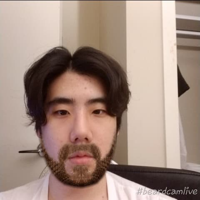

'Prediction: alligator plush; Probability: 0.8644'

In [82]:
beard = PILImage.create("beard.jpg")
display(beard.to_thumb(200,200))
pred, pred_idx, probs =learn.predict(beard)
f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

 Indeed I am an alligator plush with my fake beard!

In [38]:
learn.export()

## RUN CODE BELOW TO MAKE YOUR OWN TEST (Download export.pkl file on my github)

In [39]:
from fastai.vision.widgets import *
btn_upload = widgets.FileUpload()
out_pl = widgets.Output()
lbl_pred = widgets.Label()

In [40]:
path = Path('')
learn_inf = load_learner(path/'export.pkl', cpu=True)

In [63]:
def on_data_change(change):
    lbl_pred.value = ''
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

In [83]:
btn_upload.observe(on_data_change, names=['data'])

display(VBox([widgets.Label('Feed me a reptile photo!'), btn_upload, out_pl, lbl_pred]))